In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')

print(f"train shape: {train.shape}")

train shape: (27455, 785)


In [7]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


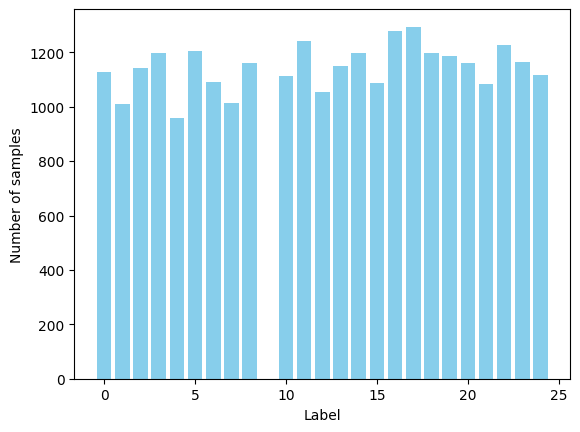

In [16]:
# 4. Class balance
counts = train['label'].value_counts().sort_index()
plt.figure()
plt.bar(counts.index, counts.values, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.show()

No sample for j (label 9)

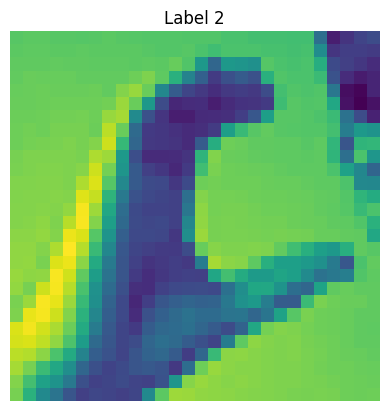

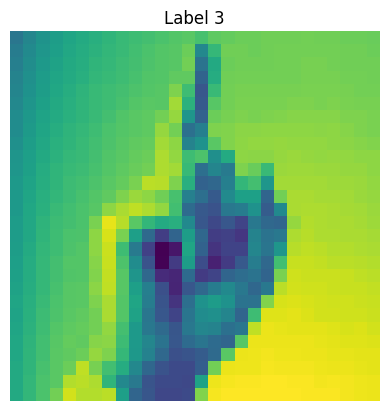

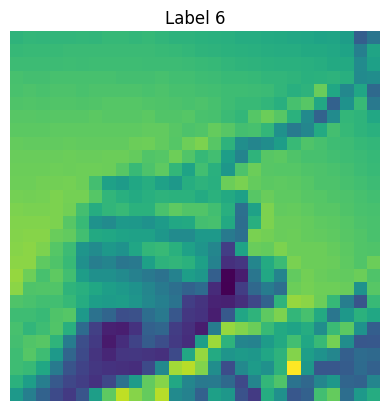

In [15]:
for lbl in [2,3,6]:
    # pick the first example of each label
    row = train[train['label']==lbl].iloc[0, 1:].values
    img = row.reshape(28, 28)
    plt.figure()
    plt.imshow(img, interpolation='nearest')
    plt.title(f'Label {lbl}')
    plt.axis('off')
    plt.show()

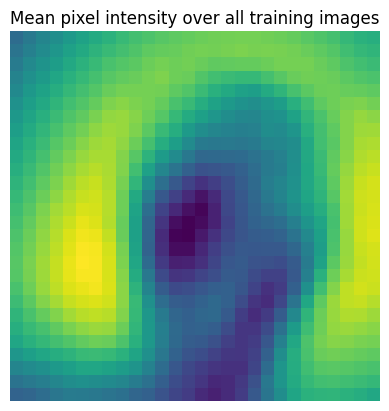

In [ ]:
# average hand shape
mean_img = train.iloc[:,1:].mean(axis=0).values.reshape(28, 28)
plt.figure()
plt.imshow(mean_img, interpolation='nearest')
plt.axis('off')
plt.show()

# CNN

In [25]:
# train.py

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# --- 1. Dataset Definition ---
class SignMNISTDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        df = pd.read_csv(csv_path)
        self.labels = df['label'].values.astype('int64')
        pixels = df.drop('label', axis=1).values.astype('float32') / 255.0
        self.images = pixels.reshape(-1, 1, 28, 28)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.from_numpy(self.images[idx])
        lbl = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, lbl

# --- 2. Model Definition ---
class SignCNN(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        # Conv‐BN blocks
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.drop1 = nn.Dropout2d(0.2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.drop2 = nn.Dropout2d(0.3)

        # Pooling and classifier
        self.pool        = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc          = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        # Block 2
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.drop1(x)
        x = self.pool(x)

        # Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.drop2(x)

        # Global pooling + FC
        x = self.global_pool(x)       # [N,128,1,1]
        x = x.view(x.size(0), -1)     # [N,128]
        return self.fc(x)             # [N,24]

# --- 3. Training & Evaluation Helpers ---
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == lbls).sum().item()
    return correct / len(loader.dataset)

# --- 4. Main Workflow ---
if __name__ == '__main__':
    # Device selection
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print("Using Apple MPS backend")
    else:
        device = torch.device('cpu')
        print("Using CPU")

    # Transforms
    train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        # input is already a FloatTensor in [0,1]
    ])
    test_transform = None

    # Load datasets
    full_train = SignMNISTDataset('sign_mnist_train.csv', transform=train_transform)
    test_ds    = SignMNISTDataset('sign_mnist_test.csv',  transform=test_transform)

    # Split into train/val
    val_frac  = 0.1
    val_size  = int(len(full_train) * val_frac)
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(
        full_train,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    # DataLoaders (num_workers=0 avoids macOS spawn issues)
    batch_size   = 64
    train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True,  num_workers=0)
    val_loader   = DataLoader(val_ds,    batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

    # Model, loss, optimizer
    model     = SignCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop with best-model checkpointing
    best_val_acc = 0.0
    num_epochs   = 30

    for epoch in range(1, num_epochs+1):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_acc    = evaluate(model, val_loader, device)
        print(f"Epoch {epoch:2d}/{num_epochs} — "
              f"Train Loss: {train_loss:.4f} — "
              f"Val Acc: {val_acc*100:5.2f}%")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_signcnn.pth')
            print(f"  → New best model saved (Val Acc: {best_val_acc*100:.2f}%)")

    print(f"\nTraining complete. Best Val Acc: {best_val_acc*100:.2f}%")
    print("Best weights are in `best_signcnn.pth`.")


Using Apple MPS backend
Epoch  1/30 — Train Loss: 2.3633 — Val Acc: 45.87%
  → New best model saved (Val Acc: 45.87%)
Epoch  2/30 — Train Loss: 1.6414 — Val Acc: 66.52%
  → New best model saved (Val Acc: 66.52%)
Epoch  3/30 — Train Loss: 1.2426 — Val Acc: 68.89%
  → New best model saved (Val Acc: 68.89%)
Epoch  4/30 — Train Loss: 0.9610 — Val Acc: 66.27%
Epoch  5/30 — Train Loss: 0.7568 — Val Acc: 80.47%
  → New best model saved (Val Acc: 80.47%)
Epoch  6/30 — Train Loss: 0.6232 — Val Acc: 87.76%
  → New best model saved (Val Acc: 87.76%)
Epoch  7/30 — Train Loss: 0.5231 — Val Acc: 89.29%
  → New best model saved (Val Acc: 89.29%)
Epoch  8/30 — Train Loss: 0.4597 — Val Acc: 90.35%
  → New best model saved (Val Acc: 90.35%)
Epoch  9/30 — Train Loss: 0.4000 — Val Acc: 87.83%
Epoch 10/30 — Train Loss: 0.3665 — Val Acc: 92.24%
  → New best model saved (Val Acc: 92.24%)
Epoch 11/30 — Train Loss: 0.3271 — Val Acc: 93.59%
  → New best model saved (Val Acc: 93.59%)
Epoch 12/30 — Train Loss: 0.

Using device: mps


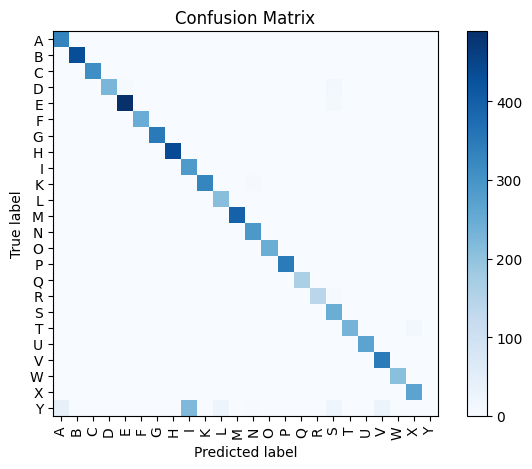

In [28]:
from sklearn.metrics import confusion_matrix
if __name__ == '__main__':
    # 2) Device
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 3) Load model
    model = SignCNN().to(device)
    model.load_state_dict(torch.load('best_signcnn.pth', map_location=device))
    model.eval()

    # 4) Prepare test loader
    test_ds = SignMNISTDataset('sign_mnist_test.csv', transform=None)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)

    # 5) Run inference
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # 6) Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # 7) Build label names (A–Y, skipping J and Z)
    labels_map = [chr(i) for i in range(65, 91) if i not in (74, 90)]

    # 8) Plot
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    tick_marks = np.arange(len(labels_map))
    plt.xticks(tick_marks, labels_map, rotation=90)
    plt.yticks(tick_marks, labels_map)
    plt.tight_layout()
    plt.show()